In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import generate_multiple_images, mixed_dataset
from scripts.autoencoders import InMemoryImageDataset, ConfigurableAutoencoder
from scripts.measuring_quality import first_order_method, co_ocurrence_matrix, deltah, second_order_method

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf
import warnings
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [3]:
config_name = 'config_4' # Elegir

config_path = f'configs/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'n': 100000, 'n_cuad_lado': [1, 2, 3], 'pixeles_cuad': [60, 30, 20], 'ratio': [0.3, 0.4, 0.3], 'num_epochs': 100, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'rlrop', 'scheduler_params': {'factor': 0.8}}, 'model': {'encoding_dim': 64, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 32, 'kernel_size': 3, 'stride': 2, 'padding': 3, 'activation': 'relu'}, {'type': 'conv2d', 'filters': 64, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'flatten'}, {'type': 'dense', 'dim': '${model.encoding_dim}', 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 16384, 'activation': 'relu'}, {'type': 'unflatten', 'dim1': 16, 'dim2': 16, 'out_channels': 64}, {'type': 'conv2d_transpose', 'filters': 32, 'kernel_size': 2, 'stride': 2, 'padding': 0, 'activation': 'relu'}, {'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 2, 'stride': 2, 'padding': 2, 'activation': 'sigmoi

In [4]:
if min(config.training.pixeles_cuad) < 8:
    warnings.warn(
        "¡El método de primer orden va a fallar!\n"
        "Existen imágenes con cuadrantes demasiado pequeños, "
        "y este método necesita zonas homogéneas más grandes.",
        category=UserWarning
    )

Cargo el autoencoder ya entrenado:

In [5]:
# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=16384, out_features=64, bias=True)
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=16384, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 16, 16))
    (3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
    (6): Sigmoid()
  )
)

Genero dataset de testeo:

In [6]:
n = config['testing']['n']
batch_size = config['testing']['batch_size']
n_cuad_lado = config['training']['n_cuad_lado']
pixeles_cuad = config['training']['pixeles_cuad']

test_g, test_gi, test_gI0, alphas = mixed_dataset(
    n_total = n,
    generate_multiple_images = generate_multiple_images,
    conjunto_n_cuad_lado = n_cuad_lado,
    conjunto_pixeles_cuad = pixeles_cuad,
    ratios = config.training.get('ratio',[1]),
    save_alpha_values=True
)

In [7]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Genero las imágenes procesadas por el autoencoder, y genero las imágenes de ratio (imagen original / imagen filtrada):

In [8]:
all_inputs = []
all_targets = []
all_outputs = []
all_ratios = []

with torch.no_grad():
    for entrada, salida in test_loader:
        entrada = entrada.float()
        salida = salida.float()
        outputs = autoencoder_cargado(entrada)
        ratios = entrada / outputs
        
        all_inputs.append(entrada.cpu().numpy())
        all_targets.append(salida.cpu().numpy())
        all_outputs.append(outputs.cpu().numpy())
        all_ratios.append(ratios.cpu().numpy())

inputs = np.squeeze(np.concatenate(all_inputs, axis=0))
targets = np.squeeze(np.concatenate(all_targets, axis=0))
outputs = np.squeeze(np.concatenate(all_outputs, axis=0))
ratios = np.squeeze(np.concatenate(all_ratios, axis=0))

Grafico un set de imágenes a modo de ejemplo:

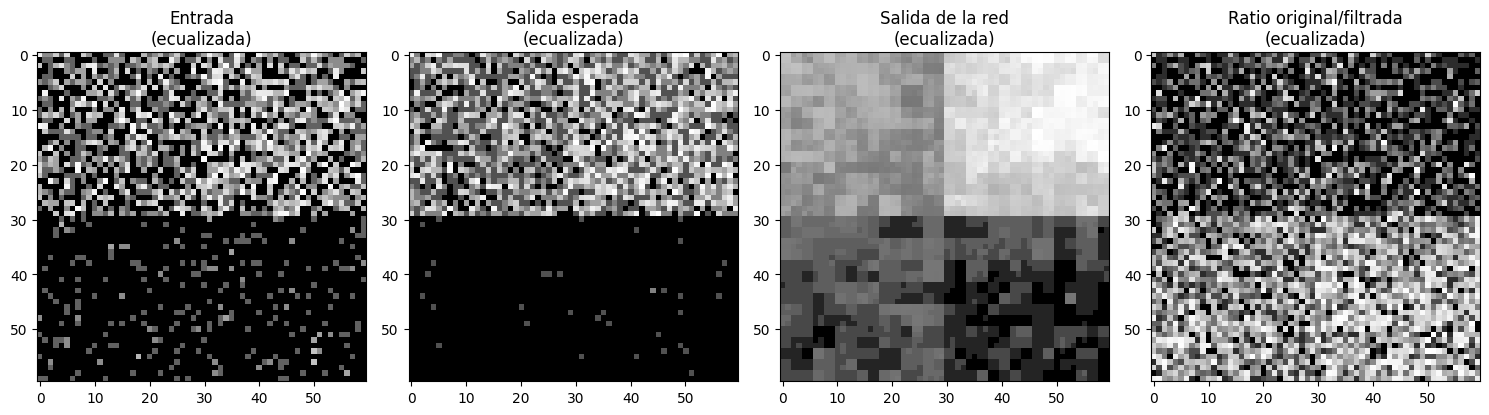

In [9]:
ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist, show_plot=True):

    index = int(n*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, target_red, salida_red, ratios = inputs[index, :, :], targets[index, :, :], outputs[index, :, :], ratios[index, :, :]

    imagenes = [entrada_red, target_red, salida_red, ratios]
    titulos = ['Entrada', 'Salida esperada', 'Salida de la red', 'Ratio original/filtrada']

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            imagen = ((imagen - imagen.min()) * 255) / (imagen.max() - imagen.min())
            imagen = cv2.equalizeHist(imagen.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()

graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist)

## Método de primer orden

In [10]:
fom = first_order_method(config.training.pixeles_cuad, alphas, inputs, ratios)

El filtro perfecto produciría un estadístico de primer orden igual a 0.

Media del estadístico de 1er orden sobre todas las imágenes: 0.34328746795654297
Desviación estándar del estadístico de 1er orden sobre todas las imágenes: 0.27851879596710205



Text(0.5, 1.0, 'Distribución del estadístico de 1er orden')

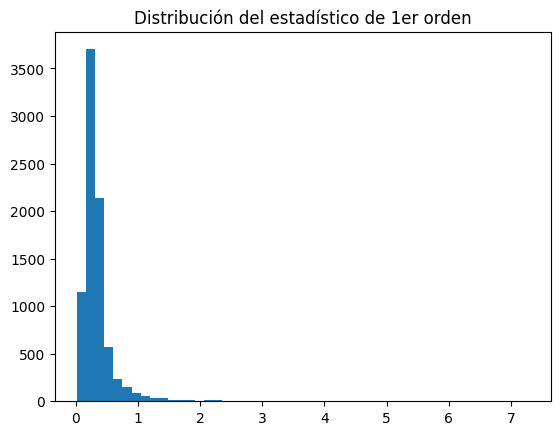

In [11]:
print(f'El filtro perfecto produciría un estadístico de primer orden igual a 0.\n')
print(f'Media del estadístico de 1er orden sobre todas las imágenes: {np.mean(fom)}')
print(f'Desviación estándar del estadístico de 1er orden sobre todas las imágenes: {np.std(fom)}\n')
plt.hist(fom, bins=50)
plt.title('Distribución del estadístico de 1er orden')

## Método de segundo orden

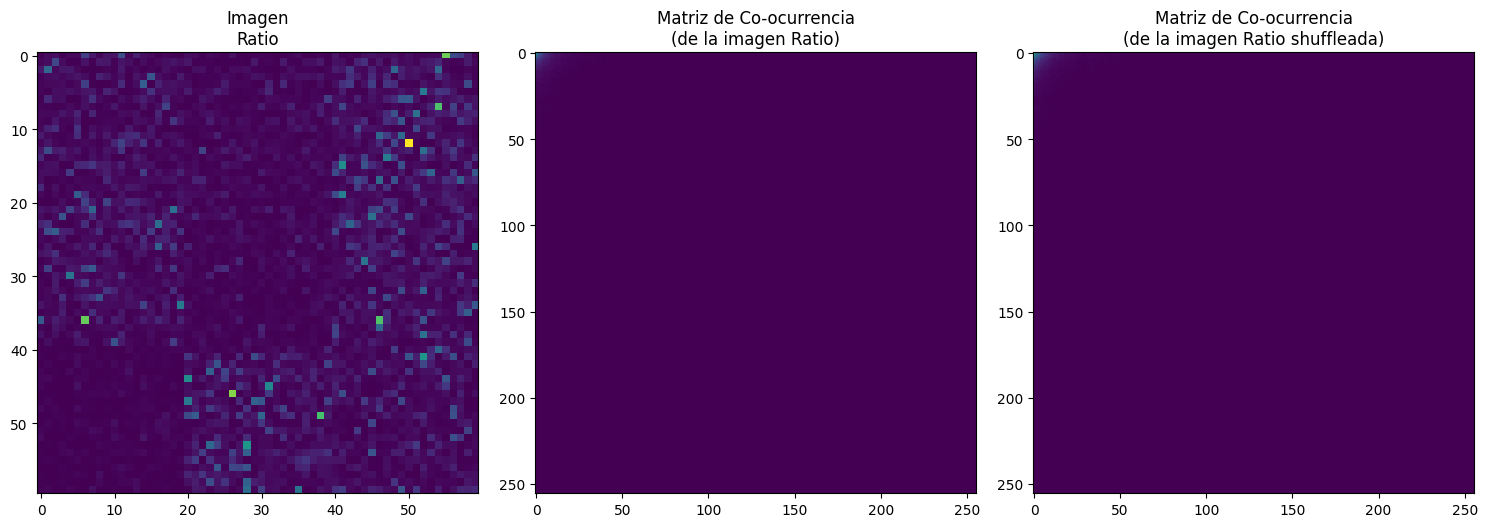

In [12]:
# Grafico solo a modo de ejemplo

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

random_index = np.random.randint(0, ratios.shape[0])
img_original = ratios[random_index]
axes[0].imshow(img_original, cmap='viridis')
axes[0].set_title("Imagen\nRatio")

glcm_avg = co_ocurrence_matrix(img_original)
axes[1].imshow(glcm_avg, cmap='viridis')
axes[1].set_title("Matriz de Co-ocurrencia\n(de la imagen Ratio)")

shuffled_flat = np.random.permutation(img_original.ravel())
shuffled_arr = shuffled_flat.reshape(img_original.shape)
glcm_avg_shuffled = co_ocurrence_matrix(shuffled_arr)
axes[2].imshow(glcm_avg_shuffled, cmap='viridis')
axes[2].set_title("Matriz de Co-ocurrencia\n(de la imagen Ratio shuffleada)")

plt.tight_layout()

In [13]:
deltah(ratios[random_index], g=30)

np.float64(12.501000680547536)

In [14]:
som = second_order_method(ratios, g=30)

Procesadas 0 imágenes de 10000
Procesadas 50 imágenes de 10000
Procesadas 100 imágenes de 10000
Procesadas 150 imágenes de 10000
Procesadas 200 imágenes de 10000
Procesadas 250 imágenes de 10000
Procesadas 300 imágenes de 10000
Procesadas 350 imágenes de 10000
Procesadas 400 imágenes de 10000
Procesadas 450 imágenes de 10000
Procesadas 500 imágenes de 10000
Procesadas 550 imágenes de 10000
Procesadas 600 imágenes de 10000
Procesadas 650 imágenes de 10000
Procesadas 700 imágenes de 10000
Procesadas 750 imágenes de 10000
Procesadas 800 imágenes de 10000
Procesadas 850 imágenes de 10000
Procesadas 900 imágenes de 10000
Procesadas 950 imágenes de 10000
Procesadas 1000 imágenes de 10000
Procesadas 1050 imágenes de 10000
Procesadas 1100 imágenes de 10000
Procesadas 1150 imágenes de 10000
Procesadas 1200 imágenes de 10000
Procesadas 1250 imágenes de 10000
Procesadas 1300 imágenes de 10000
Procesadas 1350 imágenes de 10000
Procesadas 1400 imágenes de 10000
Procesadas 1450 imágenes de 10000
Pro

El filtro perfecto produciría un estadístico de segundo orden igual a 0.

Media del estadístico de 2do orden sobre todas las imágenes: 4.946074867838421
Desviación estándar del estadístico de 2do orden sobre todas las imágenes: 4.5536235524678315



Text(0.5, 1.0, 'Distribución del estadístico de 2do orden')

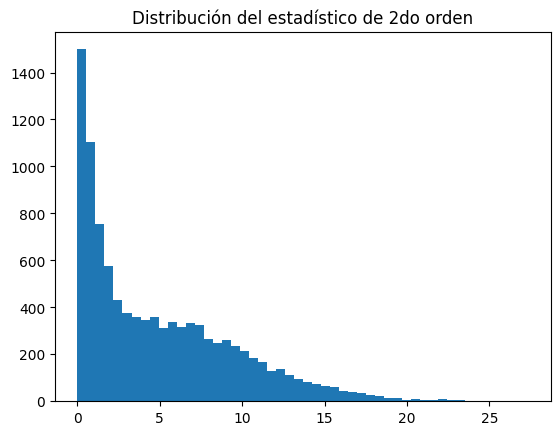

In [15]:
print(f'El filtro perfecto produciría un estadístico de segundo orden igual a 0.\n')
print(f'Media del estadístico de 2do orden sobre todas las imágenes: {np.mean(som)}')
print(f'Desviación estándar del estadístico de 2do orden sobre todas las imágenes: {np.std(som)}\n')
plt.hist(som, bins=50)
plt.title('Distribución del estadístico de 2do orden')

### Salvando los resultados

In [16]:
test_file_path = f'data/quality_filter_results.csv'

new_result = pd.DataFrame({
    'config_name': [config_name],
    'Estadístico de 1er orden': [np.mean(fom)],
    'Estadístico de 2do orden': [np.mean(som)]
})

try:
    existing_results = pd.read_csv(test_file_path)
    existing_results = existing_results[existing_results['config_name'] != config_name]
    all_results = pd.concat([existing_results, new_result], ignore_index=True)
except FileNotFoundError:
    all_results = new_result

all_results.to_csv(test_file_path, index=False)